In [1]:
import copy
import pathlib

from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from gala.units import galactic

import torusimaging as oti
from torusimaging_helpers.plot import (
    plot_bdata,
    plot_data_model_residual,
    plot_spline_functions,
)
from torusimaging_helpers.config import gala_pot, agama_pot, R0, vc0
from torusimaging_helpers.make_sim_data import make_qiso_df

jax.config.update("jax_enable_x64", True)

In [2]:
import importlib
import torusimaging.model
import torusimaging.model_spline

importlib.reload(torusimaging.model)
importlib.reload(torusimaging.model_spline)
oti.TorusImaging1DSpline = torusimaging.model_spline.TorusImaging1DSpline

In [3]:
cache_path = pathlib.Path("../cache").resolve()
cache_path.mkdir(exist_ok=True)

In [4]:
pdata_file = cache_path / "qiso-pdata.hdf5"

if not pdata_file.exists():
    pdata = make_qiso_df(N=1_000_000)
    pdata.write(pdata_file, overwrite=True, serialize_meta=True)
else:
    pdata = at.QTable.read(pdata_file)

In [5]:
Lz = pdata["J"][:, 1]

In [6]:
Lz_bin = 8.0 * u.kpc * vc0
mask = (np.abs(Lz - Lz_bin) < 0.05 * Lz_bin) & (pdata["zmax"] < 0.1 * u.kpc)
mask.sum()

np.int64(107366)

Bin by $L_z$:

In [7]:
pdata_bin = pdata[mask].copy()
# pdata_bin["x_R"] = pdata_bin["R"] - Rg[mask]

In [8]:
def make_mgfe(JR, slope=0.1 / 10, std=0.05, rng=None):
    """
    Default parameters from APOGEE in fiducial model
    """
    if rng is None:
        rng = np.random.default_rng()

    x = np.sqrt(JR)
    mgfe = slope * x + 0.0
    mgfe = rng.normal(mgfe, std)
    mgfe_err = np.exp(rng.normal(-4.0, 0.5, size=len(JR)))
    mgfe = rng.normal(mgfe, mgfe_err)
    return mgfe, mgfe_err

In [9]:
pdata_bin["mgfe"], pdata_bin["mgfe_err"] = make_mgfe(
    pdata_bin["J"][:, 0].to_value(u.km / u.s * u.kpc)
)

In [10]:
# tmp = np.nanpercentile(pdata_bin["R"].to_value(u.kpc), [0.1, 50, 99.9])
# max_v = 2 * np.nanpercentile(pdata_bin["v_R"].to_value(u.km / u.s), 99)
# plt.hist2d(
#     pdata_bin["R"].to_value(u.kpc),
#     pdata_bin["v_R"].to_value(u.km / u.s),
#     bins=(np.linspace(tmp[0], tmp[2], 101), np.linspace(-max_v, max_v, 101))
# );

In [11]:
shift = np.mean(pdata_bin["R"])

tmp = np.nanpercentile(pdata_bin["R"].to_value(u.kpc), [0.1, 50, 99.9])
xtmp = np.diff(tmp)
max_v = 2 * np.nanpercentile(pdata_bin["v_R"].to(u.km / u.s), 99)

xv_bins = {
    # "pos": np.linspace(-2 * xtmp[0], 2 * xtmp[1], 101),
    # "pos": np.linspace(tmp[0], tmp[2], 101) - shift.to_value(u.kpc),
    "pos": np.linspace(-5, 5, 101),
    "vel": np.linspace(-max_v, max_v, 101),
}

bdata = oti.data.get_binned_label(
    pdata_bin["R"] - shift,
    pdata_bin["v_R"],
    label=pdata_bin["mgfe"],
    label_err=pdata_bin["mgfe_err"],
    bins=xv_bins,
    units=galactic,
    s_N_thresh=5,
)

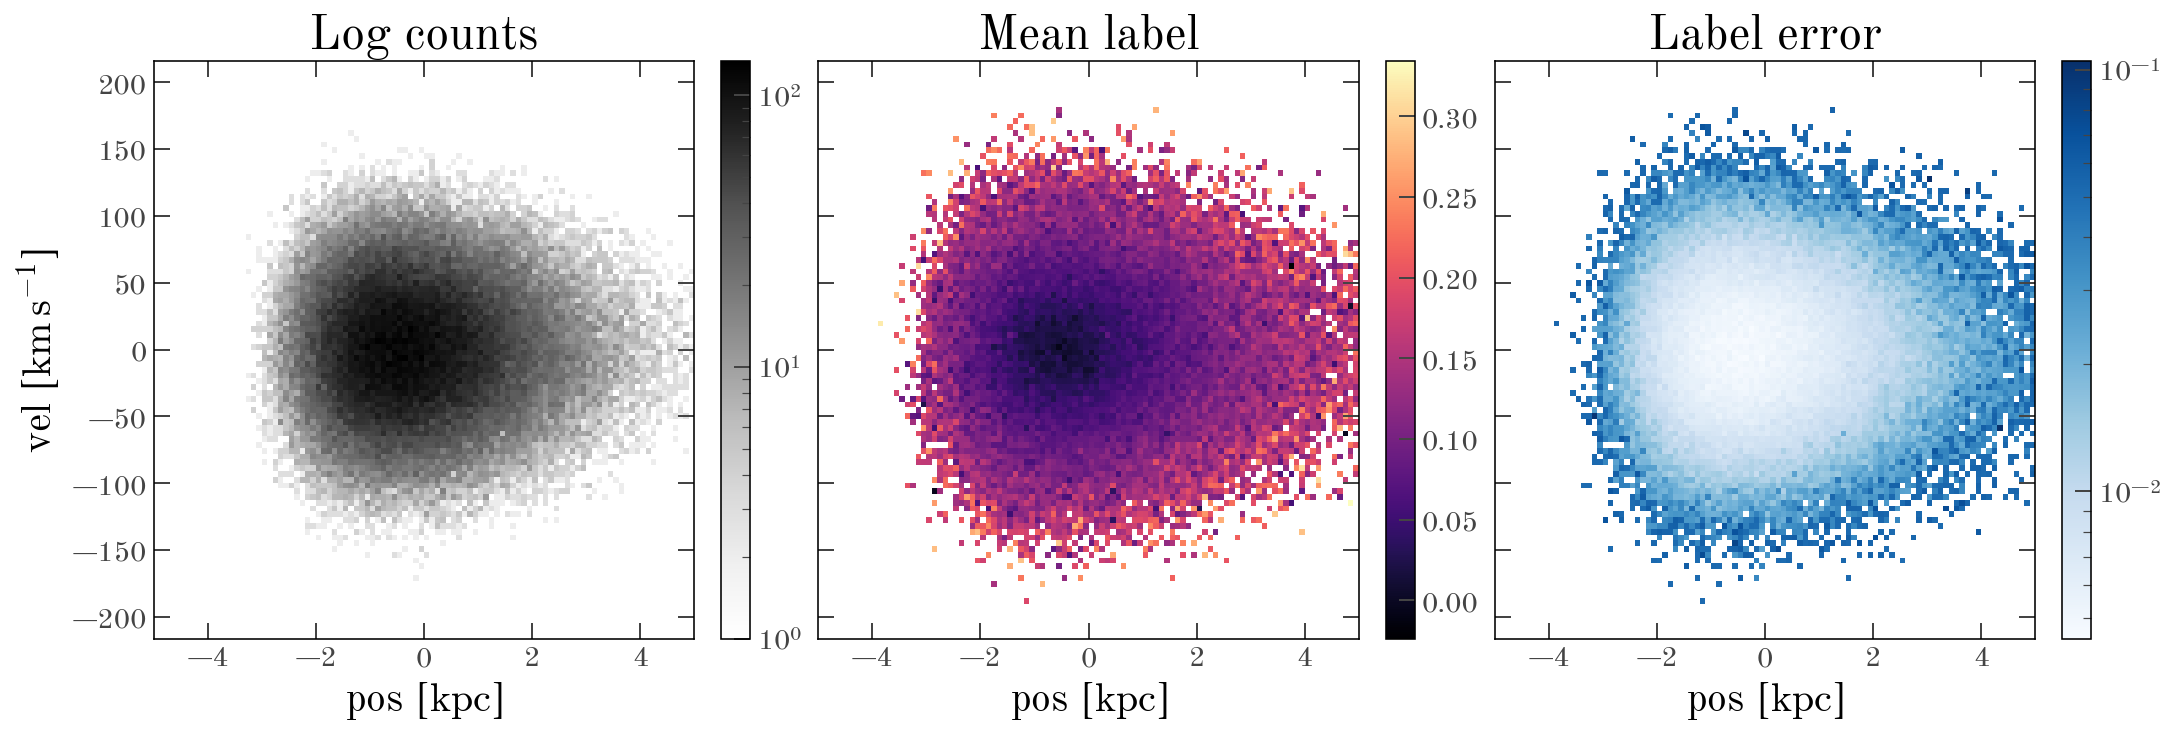

In [12]:
_ = plot_bdata(bdata, x_coord="pos")

In [13]:
model, bounds, init_params = oti.TorusImaging1DSpline.auto_init(
    bdata,
    label_knots=8,
    e_knots={1: 8, 2: 8, 3: 4, 4: 4},
    label_l2_sigma=1.0,
    label_smooth_sigma=0.5,
    e_l2_sigmas={1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0},
    e_signs={1: -1, 3: -1},
    e_smooth_sigmas={1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1},
    dacc_strength=0.0,
    label_knots_spacing_power=0.75,
    e_knots_spacing_power=0.5,
    bounds={"pos0": [-3, 3] * u.kpc},
    elliptical_angle_convention="vp",
)

init_params["e_params"][1]["vals"] = np.full_like(
    init_params["e_params"][1]["vals"],
    -0.5,  # np.log(0.05 / model._label_knots.max())
)
init_params["e_params"][2]["vals"] = np.full_like(
    init_params["e_params"][2]["vals"], -2
)
init_params["e_params"][3]["vals"] = np.full_like(
    init_params["e_params"][3]["vals"],
    -0.5,  # np.log(0.05 / model._label_knots.max())
)
init_params["e_params"][4]["vals"] = np.full_like(
    init_params["e_params"][4]["vals"], np.log(0.05 / model._label_knots.max())
)

In [14]:
data_kw = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
data_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
data_kw = {k: v[data_mask] for k, v in data_kw.items()}

In [15]:
test_val = model.objective_gaussian(init_params, **data_kw)
print(f"Test evaluation of objective function: {test_val}")

Test evaluation of objective function: 6.8285596946710365


In [16]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **data_kw)

In [17]:
params = copy.deepcopy(res.params)
# params["e_params"][1]["vals"] = jnp.full_like(params["e_params"][3]["vals"], -1.0)
# params["e_params"][3]["vals"] = jnp.full_like(params["e_params"][3]["vals"], -1.0)

res.params

{'e_params': {1: {'vals': Array([-1.04152467, -1.04121599, -1.04439223, -1.07249762, -1.1100456 ,
          -1.10511982, -1.11342514], dtype=float64)},
  2: {'vals': Array([-2.23924718, -2.23586484, -2.22862543, -2.21305998, -2.19156053,
          -2.19099983, -2.18761713], dtype=float64)},
  3: {'vals': Array([-2.24712426, -2.24461456, -2.25450393], dtype=float64)},
  4: {'vals': Array([-4.5257145 , -4.52244237, -4.52111621], dtype=float64)}},
 'label_params': {'label_vals': Array([0.00734973, 0.16383355, 0.23072289, 0.21689437, 0.24967122,
         0.29023432, 0.18431619, 0.23912182], dtype=float64)},
 'ln_Omega0': Array(-3.33228556, dtype=float64),
 'pos0': Array(-0.52619332, dtype=float64),
 'vel0': Array(0.00017367, dtype=float64)}

In [18]:
res.params["pos0"] + shift.to_value(u.kpc)

Array(7.98407106, dtype=float64)

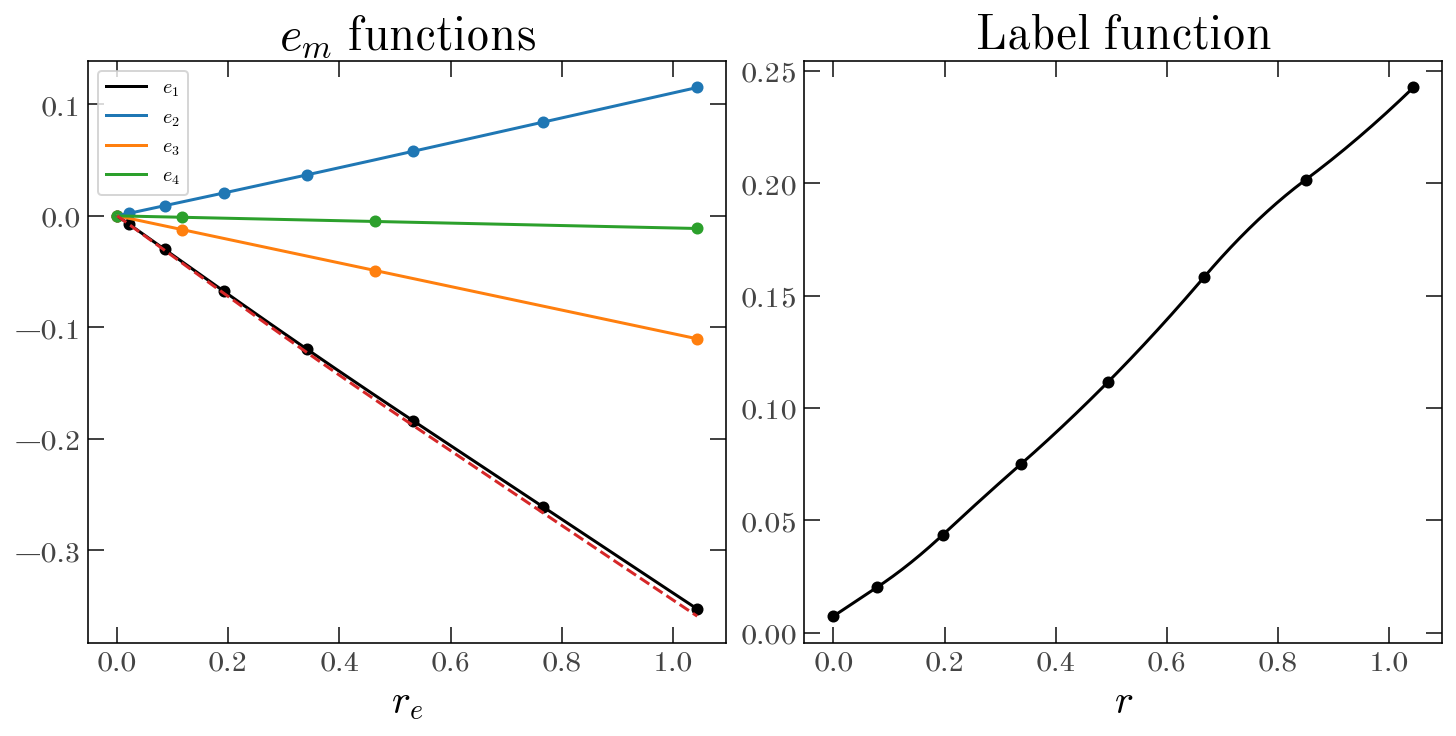

In [19]:
_ = plot_spline_functions(model, params)

In [20]:
bdata["pos"].min()

<Quantity -4.95 kpc>

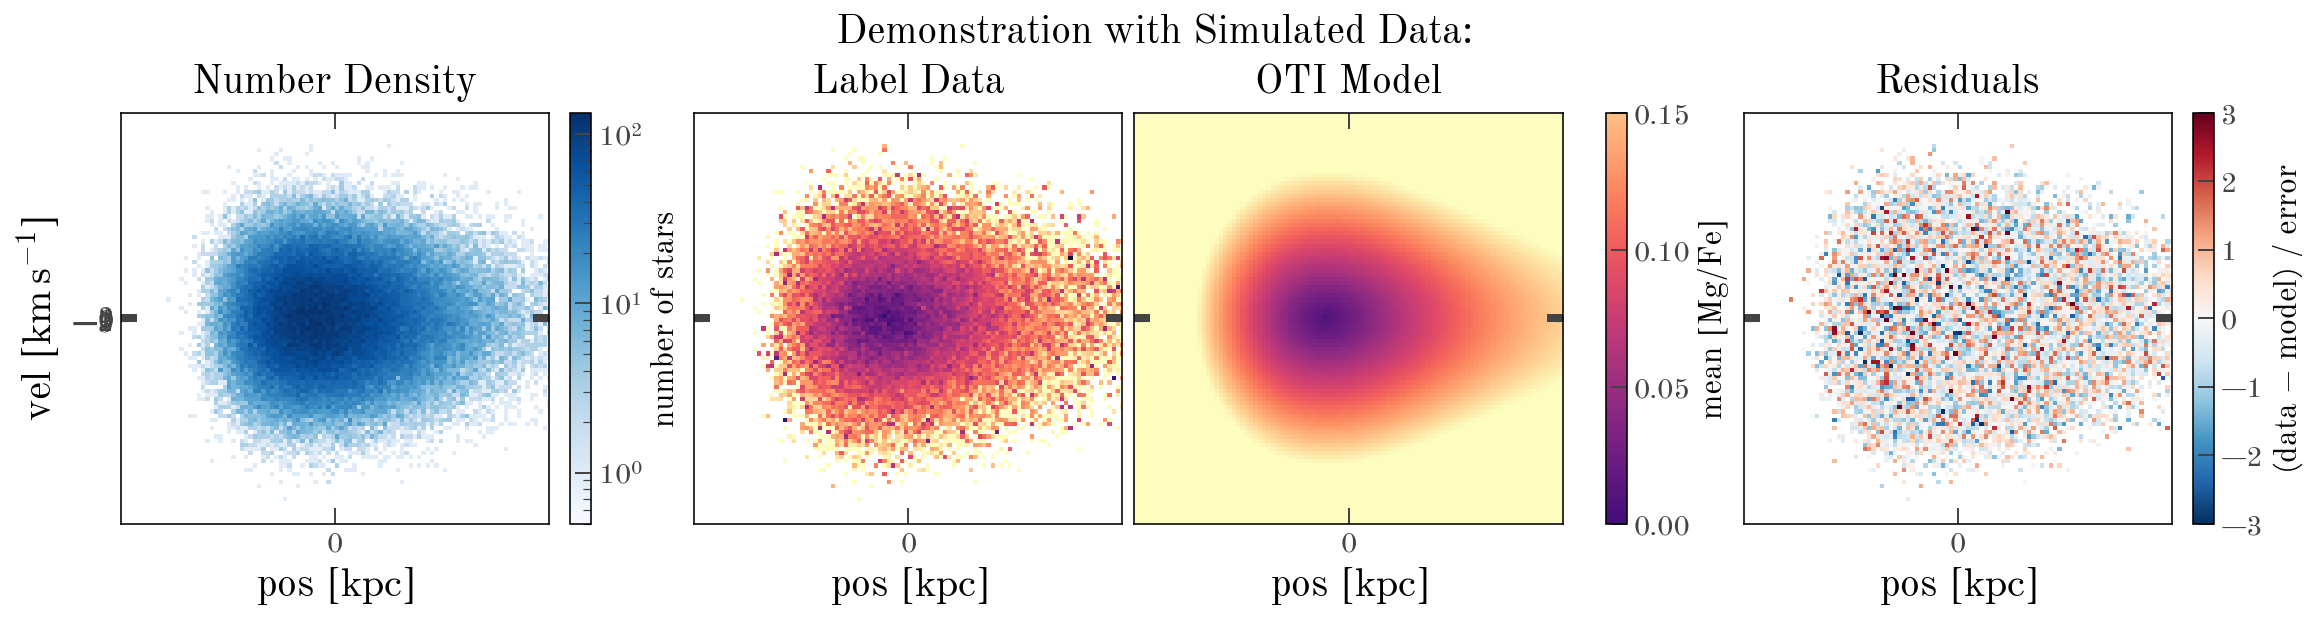

In [21]:
fig, axes = plot_data_model_residual(
    model,
    bdata,
    params,
    # pos_lim=2 * xtmp[1] * u.kpc,
    # vel_lim=200 * u.km / u.s,
    pos_lim=(bdata["pos"].max() - bdata["pos"].min()) / 2,
    vel_lim=(bdata["vel"].max() - bdata["vel"].min()) / 2,
    aspect=False,
    suptitle2="",
    x_coord="pos",
)

In [22]:
a_unit = u.km / u.s / u.Myr

# Set x_grid based on where we have data to avoid extrapolation
x_data = (pdata_bin["R"] - shift).to_value(u.kpc)
x_grid = np.linspace(*np.percentile(x_data, [5, 95]), 1024) * u.kpc
print(x_grid.min(), x_grid.max())

bestfit_aR = model.get_acceleration(x_grid, params).to(a_unit)

RR = x_grid + shift
Lz_term = Lz_bin**2 / RR**3

# The acceleration a_R = -dPhi_eff/dR = -dPhi/dR + Lz^2 / R^3
# So: dPhi/dR = -a_R + Lz^2 / R^3
bestfit_dPhi_dR = -bestfit_aR + Lz_term
bestfit_sqrtRdPhi_dR = np.sqrt(RR * bestfit_dPhi_dR)  # circ vel

-1.9760493144487004 kpc 2.551453401553035 kpc


Now do error samples? (not bootstrap, yet)

In [23]:
err_samples = model.get_crlb_error_samples(params, data_kw, size=256)

In [24]:
samples_aR = []
for pp in err_samples:  # TODO: need to reshape leaves in method...
    pp = jax.tree.map(lambda x: np.squeeze(x), pp)
    samples_aR.append(model.get_acceleration(x_grid, pp))

samples_aR = u.Quantity(samples_aR).to(a_unit)

samples_dPhi_dR = -samples_aR + Lz_term
samples_sqrtRdPhi_dR = np.sqrt(RR * samples_dPhi_dR)

In [25]:
Rg_at_bin = shift + params["pos0"] * u.kpc
vc_at_bin = Lz_bin / Rg_at_bin

In [26]:
true_dPhi_dR = gala_pot.gradient(R=shift + x_grid)[0]
true_vcirc = gala_pot.circular_velocity(R=shift + x_grid)

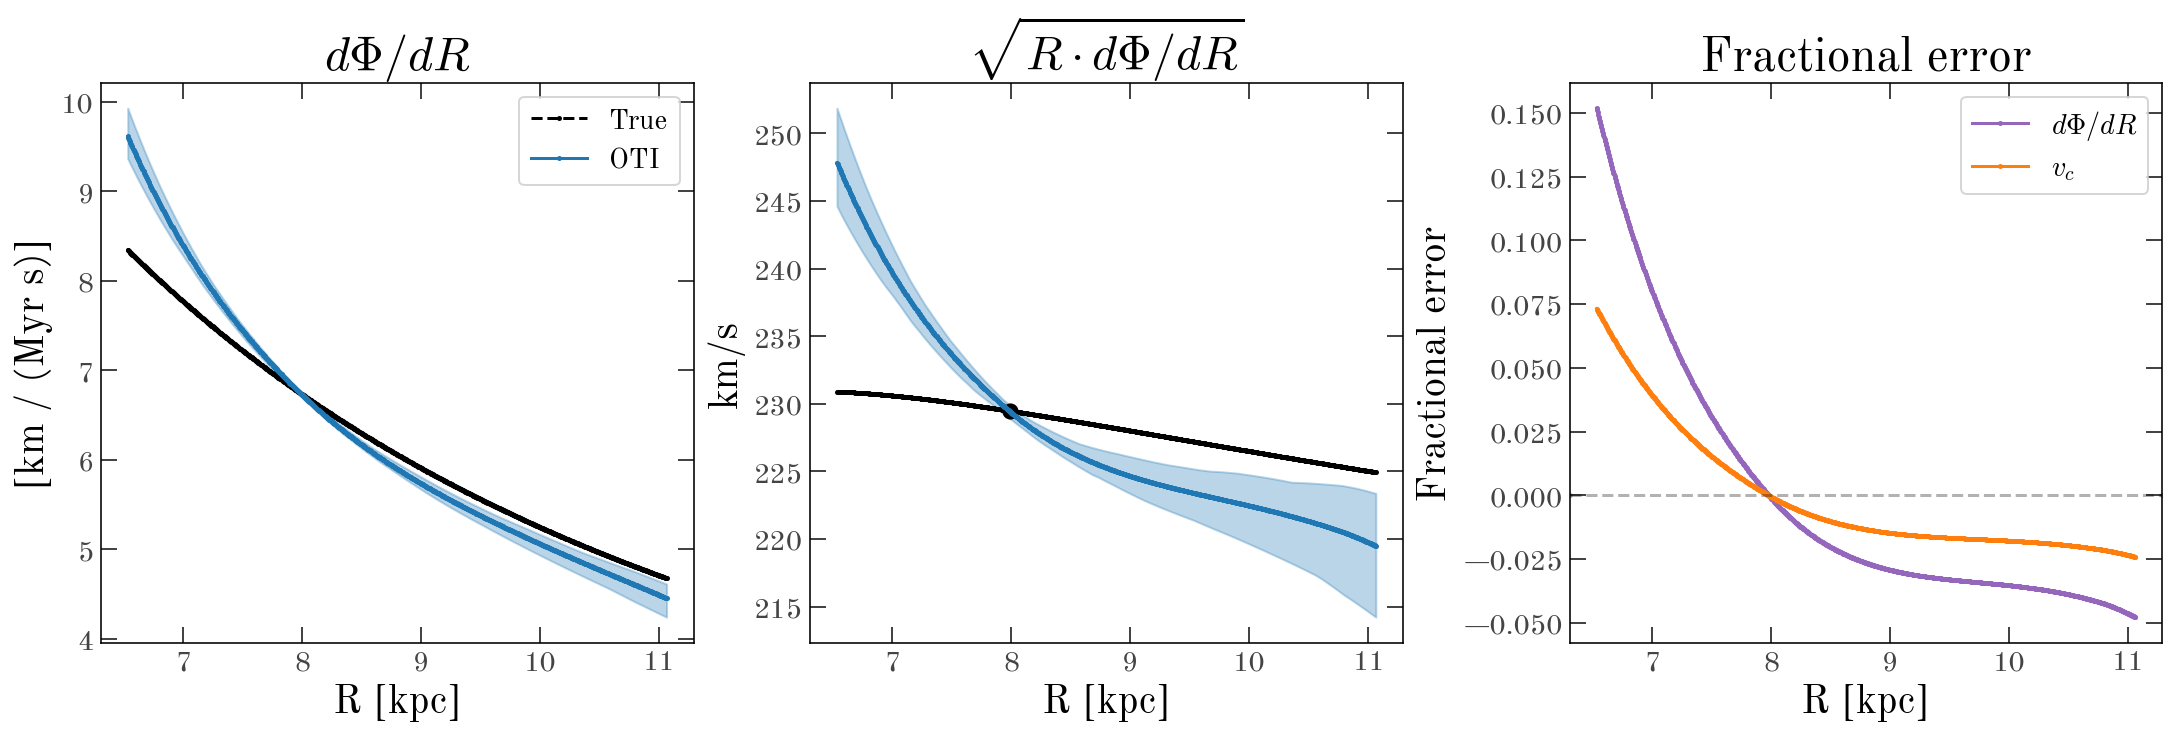

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), layout="constrained")

ax = axes[0]
ax.set_title(r"$d\Phi/dR$")
ax.plot(RR.value, true_dPhi_dR.to_value(a_unit), label="True", ls="--")
ax.plot(RR.value, bestfit_dPhi_dR.to_value(a_unit), label="OTI")
ax.fill_between(
    RR.value,
    np.percentile(samples_dPhi_dR.to_value(a_unit), 1, axis=0),
    np.percentile(samples_dPhi_dR.to_value(a_unit), 99, axis=0),
    color="C1",
    alpha=0.3,
    zorder=-10,
)
ax.set_xlabel("R [kpc]")
ax.set_ylabel(f"[{a_unit}]")
ax.legend(fontsize=14)

ax = axes[1]
ax.set_title(r"$\sqrt{R \cdot d\Phi/dR}$")
ax.plot(RR.value, true_vcirc.to_value(u.km / u.s), label="True", ls="--")
ax.plot(RR.value, bestfit_sqrtRdPhi_dR.to_value(u.km / u.s), label="OTI")
ax.scatter(
    Rg_at_bin.to_value(u.kpc),
    vc_at_bin.to_value(u.km / u.s),
    color="k",
    s=50,
    label="from pos0",
)
ax.fill_between(
    RR.value,
    np.percentile(samples_sqrtRdPhi_dR.to_value(u.km / u.s), 1, axis=0),
    np.percentile(samples_sqrtRdPhi_dR.to_value(u.km / u.s), 99, axis=0),
    color="C1",
    alpha=0.3,
    zorder=-10,
)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("km/s")

ax = axes[2]
ax.set_title("Fractional error")
frac_err_dPhi = (bestfit_dPhi_dR - true_dPhi_dR) / true_dPhi_dR
frac_err_vc = (bestfit_sqrtRdPhi_dR - true_vcirc) / true_vcirc
ax.plot(RR.value, frac_err_dPhi.decompose(), label=r"$d\Phi/dR$", color="tab:purple")
ax.plot(RR.value, frac_err_vc.decompose(), label=r"$v_c$", color="tab:orange")
ax.axhline(0, color="k", ls="--", alpha=0.3)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("Fractional error")
ax.legend(fontsize=14)